Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


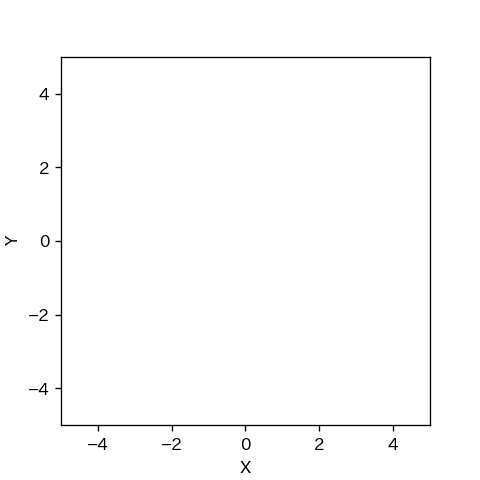

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

<IPython.core.display.Javascript object>


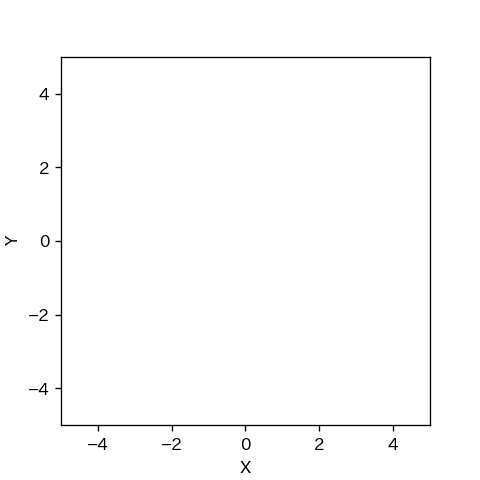

(array([-2.16253687, -0.66894963,  2.67232127]),
 array([ 0.11288746,  3.84745792, -0.77942134]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[4.175409149361285]
0 真値: [-2.68705741  1.02458253  5.23674524] 推定値: [-4.08298886  0.33163803  4.2299989 ] 誤差: 1.558459720800072
[1.6259787810762667]
1 真値: [4.00466341 2.62448361 6.88277576] 推定値: [4.37424675 2.28528576 0.38482627] 誤差: 0.5016443255741658
1
[2.0351550497124653]
2 真値: [-2.07364664  4.55663692  3.51870728] 推定値: [-2.42173402  4.70467946  3.60140608] 誤差: 0.3782610463254304
2
[3.5219657749887205]
[5.328924428883461]
3 真値: [-0.35459543 -1.08132449  3.31252223] 推定値: [ 1.41964834 -1.93540795  3.3155271 ] 誤差: 1.969111348105149
4 真値: [1.9499076  0.58592122 1.92560572] 推定値: [2.2161563  0.66957553 8.20740754] 誤差: 0.27908137892305523
3
[3.830570194579164]
5 真値: [-1.19614377 -3.35662042  4.5712073 ] 推定値: [ 1.61402793 -1.88074982  5.04220597] 誤差: 3.1741548515113833
[2.3151702289012968]
[5.291061837205385, 2.489981135038638]
6 真値: [5.29751745 1.01447868 8.87147721] 推定値: [5.21247355 1.39448717 8.99299202] 誤差: 0.3894084181269303
4
7 真値: [-2.39512885 -1.21593998  6.89681321] 推定値: [-3.06082

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [ 3.20172526 -3.76961724  5.57892982] 推定値: [ 3.45438733 -3.0697838   6.19449964] 誤差: 0.7440463526757563
9
[3.463626065923939]
21 真値: [4.58431704 3.70262911 4.30541234] 推定値: [1.08100977 2.52184583 0.89192666] 誤差: 3.696946170272437
[3.607281474581716]
22 真値: [-1.96816356 -0.10719653  4.64065897] 推定値: [-2.25658423 -0.02743235  4.57940702] 誤差: 0.2992470707842951
10
[3.8416979685041337]
23 真値: [-4.32538016 -0.43546492  8.29724985] 推定値: [-4.52375543 -0.13814252  1.89584026] 誤差: 0.3574260101631437
11
[2.7973455068481297]
24 真値: [-1.38811619 -0.79066196  3.66888073] 推定値: [-1.49413708 -0.79765427  3.92418843] 誤差: 0.10625121082778399
12
[4.4100836480246715]
[5.356443560728247]
25 真値: [-1.51341817 -1.218628    7.02194654] 推定値: [ 4.77537416 -6.74525754  3.35092045] 誤差: 8.37212893773456
[0.6830853454869972]
26 真値: [1.83428127 1.40678887 6.67705394] 推定値: [2.37486545 1.13801469 7.02500378] 誤差: 0.6037141826192043
13
[1.982503271272342]
27 真値: [4.66545769 1.95296724 1.74516078] 推定値: [ 2.28008011